In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm
import pandas as pd

sys.path.append('..')
from sim_biology import p, load_dataloader_and_pretrained_model, dataloader_to_nparrays
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts
from wave_attributions import Attributer
from visualize import cshow, plot_1dreconstruct, plot_1dfilts

## load data and model

In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p)

In [15]:
dirs = ["db5_sparsity_warmstart_lamL1attr=0_seed=100"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/ex_biology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.1).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

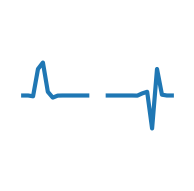

Hyperparameter: lamL1wave=0.065510 lamL1attr=0.000000


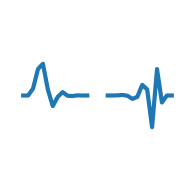

In [16]:
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
index = {}
for i in range(50):
    index[i] = np.argsort(lamL1wave)[i]

ix = 10
wt = mos[index[ix]]
filt = get_1dfilts(wt)
plot_1dfilts(filt, figsize=(1,1))

print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index[ix]], res['lamL1attr'][index[ix]]))

# original wavelet
wt_o = DWT1d(wave=res['wave'][0], mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)
filt_o = get_1dfilts(wt_o)
plot_1dfilts(filt_o, figsize=(1,1))

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
wt = wt.to('cpu')

(X, y), (X_test, y_test) = dataloader_to_nparrays(wt, train_loader, test_loader)
clf = LogisticRegression(penalty='l1', solver='saga', max_iter=1e6, tol=1e-6, warm_start=True, random_state=0)

Cs = np.arange(0.001, 1, 0.001)
errs = np.empty(len(Cs))
nnzs = np.empty(len(Cs))
for i, C in enumerate(Cs):
    print('\riteration {}/{}'.format(i, len(Cs)), end='')
    clf.set_params(C=C)
    clf.fit(X, y)
    preds = clf.predict(X_test)
    error = abs(preds - y_test).sum()/X_test.shape[0]
    errs[i] = error
    nnzs[i] = np.sum(clf.coef_ != 0)

iteration 998/999

In [19]:
wt_o = wt_o.to('cpu')

(X, y), (X_test, y_test) = dataloader_to_nparrays(wt_o, train_loader, test_loader)
clf = LogisticRegression(penalty='l1', solver='saga', max_iter=1e6, tol=1e-6, warm_start=True, random_state=0)

Cs = np.arange(0.001, 1, 0.001)
errs_o = np.empty(len(Cs))
nnzs_o = np.empty(len(Cs))
for i, C in enumerate(Cs):
    print('\riteration {}/{}'.format(i, len(Cs)), end='')
    clf.set_params(C=C)
    clf.fit(X, y)
    preds = clf.predict(X_test)
    error = abs(preds - y_test).sum()/X_test.shape[0]
    errs_o[i] = error
    nnzs_o[i] = np.sum(clf.coef_ != 0)

iteration 998/999

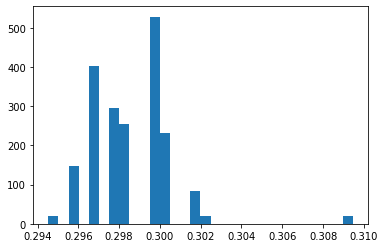

In [20]:
plt.hist(errs[nnzs < 10], density=True, bins=30)
plt.show()

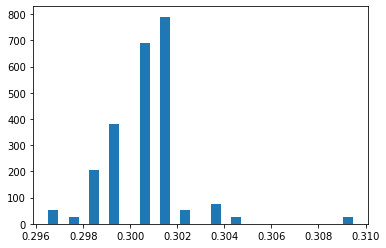

In [21]:
plt.hist(errs_o[nnzs_o < 10], density=True, bins=30)
plt.show()